# Compressed sensing project : study of non-negative matrix factorization and online dictionary learning

## First part : non-negative matrix factorization

We wanted here to study Seung & Lee's "Algorithms for Non-negative Matrix Factorization" paper. They propose two types of non-negative factorization (NMF) : one that minimizes a least-squares distance and one that minimizes the Kullback-Leibler divergence (in the case that our initialization matrix is a probability matrix).



In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as lin

__Least square NMF__

Here is the problem setting:

Given a matrix $V$ living in $\mathbb{R}^{n,m}$ we want to find matrices $W\in\mathbb{R}^{n,k}$ and $H\in\mathbb{R}^{k,m}$ solutions of the following minimization problem:

$$
\text{minimize }||V-WH||^2\text{ under constraints } W,H>0
$$


The algorithm, similarly to a classical gradient descent, will start with random W and H. Then we will apply the following update rules allowing us to converge to a local minima (the problem is non convex w.r.t. W,H).

$$
H \leftarrow H\odot\frac{W^TV}{W^TWH}
$$

$$
W \leftarrow W\odot\frac{VH^T}{WHH^T}
$$

With $\odot$ standing for element-wise product and $-$ standing for element-wise division

In [61]:
def update_h(V,W,H):
    factor1 = np.dot(W.T,V)
    factor2 = np.dot(np.dot(W.T,W),H)
    return H*factor1/factor2

In [62]:
def update_w(V,W,H):
    factor1 = np.dot(V,H.T)
    factor2 = np.dot(W,np.dot(H,H.T))
    return W*factor1/factor2
        

In [63]:
def error(V,W,H):
    return lin.norm(V-np.dot(W,H))

In [64]:
def non_negative_threshold(Z):
    neg_coefs = Z<0
    Z[neg_coefs] = 0
    return Z

In [77]:
def solver(V,W,H,t=100,verbose=False):
    err=[]
    for i in range(t):
        W_new = update_w(V,W,H)
        W = W_new
        H_new = update_h(V,W,H)
        H = H_new
        if verbose==True:
            print error(V,W,H)
        err.append(error(V,W,H))
    
    return W,H,err

In [84]:
from sklearn.datasets import fetch_lfw_people
dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
V = dataset.data

n,m = V.shape
k = 150
iterations = 500
H = non_negative_threshold(15+np.random.randn(k, m))
W = non_negative_threshold(15+np.random.randn(n, k))

In [85]:
W,H,err = solver(V,W,H,iterations)


In [86]:
def plot_faces(faces, n_rows=4, n_cols=8, label=True):
    plt.figure(figsize=(14, 10))
    n_rows, n_cols = 4, 8
    face_shape = (50, 37)
    for k, flat_face in enumerate(faces):
        if k >= n_rows * n_cols:
            break
        face = flat_face.reshape(face_shape)
        plt.subplot(n_rows, n_cols, k+1)
        plt.imshow(face, cmap=plt.cm.gray, interpolation='none')
        plt.xticks(())
        plt.yticks(())
        if label:
            plt.title(target_names[y[k]], size=10)

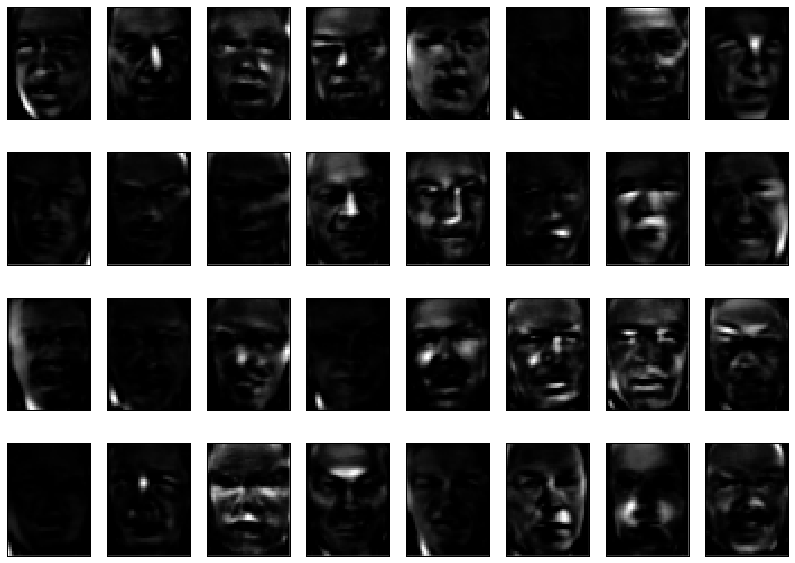

In [87]:
plot_faces(H,label=False)

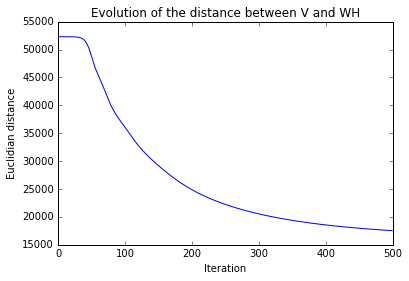

In [88]:
plt.plot(np.arange(len(err)),err)
plt.xlabel("Iteration")
plt.ylabel("Euclidian distance")
plt.title("Evolution of the distance between V and WH")

__Kullback-Leibler NMF__

Here the problem setting is similar, the only diference resides in the distance minimized:

Given a matrix $V$ living in $\mathbb{R}^{n,m}$ we want to find matrices $W\in\mathbb{R}^{n,k}$ and $H\in\mathbb{R}^{k,m}$ solutions of the following minimization problem:

$$
\text{minimize }KL(V,WH)\text{ under constraints } W,H>0
$$


Here again, Lee and Seung propose a multiplicative update rule rewritten using a similar paper "MULTIPLICATIVE UPDATE RULES FOR NONNEGATIVE MATRIX FACTORIZATION WITH CO-OCCURRENCE CONSTRAINTS" (http://sig.umd.edu/publications/Tjoa_ICASSP2_201003.pdf)

$$
H \leftarrow H\odot \frac{W^T\frac{V}{WH}}{W^T\mathbb{1}^{n,m}}
$$

$$
W \leftarrow W\odot \frac{\frac{V}{WH}H^T}{\mathbb{1}^{n,m}H^T}
$$

with $\odot$ the element-wise matrix product, $-$ the element-wise division and $\mathbb{1}^{n,m}$ the real-valued matrix of size $(n,m)$ with all its coefficients equal to 1.

In [107]:
def update_h(V,W,H):
    n,m = V.shape
    unit_vector = np.ones((n,m))
    factor1 = np.dot(W.T,V/np.dot(W,H))
    factor2 = np.dot(W.T,unit_vector)
    return H*factor1/factor2

def update_w(V,W,H):
    n,m = V.shape
    unit_vector = np.ones((n,m))
    factor1 = np.dot(V/np.dot(W,H),H.T)
    factor2 = np.dot(unit_vector,H.T)
    return W*factor1/factor2

def normalize(Z):
    norm = Z.sum(axis=1).sum()
    Z_new = Z.astype(float)/norm
    return Z_new


In [124]:
from sklearn.datasets import fetch_lfw_people
dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
V = dataset.data

n,m = V.shape
k = 150
iterations = 50
H = non_negative_threshold(15+np.random.randn(k, m))
W = non_negative_threshold(15+np.random.randn(n, k))
V = normalize(V) #Here it is compulsory to renormalize V so that the sum of its coefficients equals 1 (V should be a propability matrix)

In [120]:
W,H,err = solver(V,W,H,iterations,verbose=True)

0.000166000538623
0.00016599960582
0.00016599864543
0.000165997641692
0.000165996575503
0.000165995425246
0.000165994165882
0.000165992767885
0.000165991195946
0.000165989407394
0.000165987350256
0.00016598496085
0.000165982160788
0.000165978853254
0.000165974918331
0.000165970207185
0.000165964534761
0.000165957670667
0.000165949327746
0.000165939147806
0.000165926683783
0.000165911377503
0.000165892532001
0.000165869277186
0.000165840527403
0.000165804929261
0.000165760797952
0.00016570604022
0.000165638062375
0.000165553662288
0.000165448905592
0.000165318988623
0.00016515809451
0.000164959254999
0.000164714239715
0.000164413507238
0.000164046268351
0.000163600729504
0.000163064598878
0.000162425939205
0.000161674425522
0.000160802993835
0.00015980973454
0.000158699699809
0.000157486107483
0.000156190338047
0.000154840263034
0.000153466880303
0.000152099869474
0.000150763235459


In [123]:
np.dot(W,H).sum(axis=0).sum()

0.99999999993112687

# Second part: Online Structured Dictionary Learning

## 1. Load MovieLens
Source : http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/

In [1]:
cd ml-100k/

C:\Users\Guillaume\Documents\Scolarite\MasterDataSciences\Projets\Compressed Sensing\ml-100k


In [2]:
ls

 Le volume dans le lecteur C s'appelle OS
 Le num‚ro de s‚rie du volume est 325A-0B30

 R‚pertoire de C:\Users\Guillaume\Documents\Scolarite\MasterDataSciences\Projets\Compressed Sensing\ml-100k

29/01/2016  14:26    <DIR>          .
29/01/2016  14:26    <DIR>          ..
19/07/2000  15:09               716 allbut.pl
19/07/2000  15:09               643 mku.sh
29/01/2016  14:26             6ÿ750 README
19/07/2000  15:09         1ÿ979ÿ173 u.data
19/07/2000  15:09               202 u.genre
19/07/2000  15:09                36 u.info
19/07/2000  15:09           236ÿ344 u.item
19/07/2000  15:09               193 u.occupation
19/07/2000  15:09            22ÿ628 u.user
08/03/2001  12:33         1ÿ586ÿ544 u1.base
08/03/2001  12:32           392ÿ629 u1.test
08/03/2001  12:33         1ÿ583ÿ948 u2.base
08/03/2001  12:33           395ÿ225 u2.test
08/03/2001  12:33         1ÿ582ÿ546 u3.base
08/03/2001  12:33           396ÿ627 u3.test
08/03/2001  12:33         1ÿ581ÿ878 u4.base
08/03/2001  12:33     

In [7]:
import numpy as np
import pandas as pd

In [10]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [15]:
rating_scale = sorted(df.rating.unique())
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print str(rating_scale) + ' rating_scale'
print str(n_users) + ' users'
print str(n_items) + ' items'

[1, 2, 3, 4, 5] rating_scale
943 users
1682 items


In [16]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

In [17]:
ratings.shape

(943L, 1682L)

In [26]:
def sparsity(ratings):
    spars = float(len(ratings.nonzero()[0]))
    spars /= (ratings.shape[0] * ratings.shape[1])
    spars *= 100
    print 'Sparsity: {:4.2f}%'.format(spars)

In [27]:
sparsity(ratings)

Sparsity: 6.30%


## 2. Coder une cross_validation

In [22]:
# Remove 10 ratings per user from the training set, that we put in the testing set
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[0, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.                               # we put these ratings at 0 in the training set
        test[user, test_ratings] = ratings[user, test_ratings]       # we put them in the testing set
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [23]:
train, test = train_test_split(ratings)

In [24]:
train.shape

(943L, 1682L)

In [28]:
sparsity(train)

Sparsity: 6.21%


In [25]:
test.shape

(943L, 1682L)

In [29]:
sparsity(test)

Sparsity: 0.10%


## 3. CF

In [35]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])

In [36]:
item_similarity_1(a, b, 0.01)

0.99974307828069164

In [34]:
## Define similarities

# Normalized scalar product based similarity
def item_similarity_1(q_i, q_j, alpha):
    a = (q_i ).T.dot(q_j)
    b = q_i.T.dot(q_i)
    c = q_j.T.dot(q_j)
    
    s_ij = (max(0, a) / np.sqrt(b * c))** alpha
    
    return s_ij

# Normalized Euclidian distance based similarity
def item_similarity_2(q_i, q_j, alpha):
    a = (q_i - q_j).T.dot(q_i - q_j)
    b = q_i.T.dot(q_i)
    c = q_j.T.dot(q_j)
    
    s_ij = (a / np.sqrt(b * c))**(- alpha)
    
    return s_ij

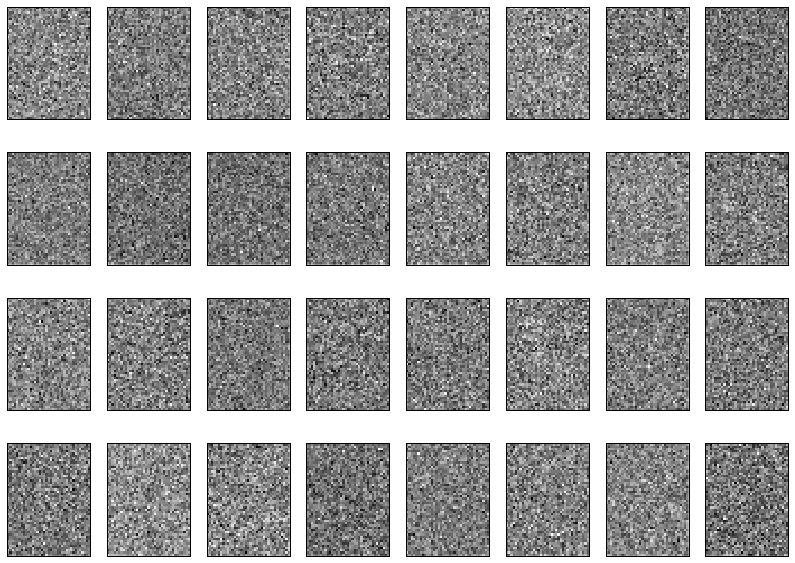

In [127]:
plot_faces(H,label=False)